<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/model_embedding_concat_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install ktrain
!pip install -q pytorch_lightning==1.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 38.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.4/265.4 KB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 32.9 MB/s eta 0:00

In [2]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
import os
import re
import copy

import math
from typing import Optional
import transformers
from ktrain import text

import torch
import torch.utils.checkpoint as checkpoint
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW, DataCollatorWithPadding
from tensorflow.keras.layers import GlobalAveragePooling1D

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import pickle
import re
from transformers import TrainingArguments, AutoConfig, AutoModelForTokenClassification, DataCollatorForTokenClassification

In [3]:
df = pd.read_csv('train.csv')
df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex = True)

label_cols = df.columns[2:]
pred_col_list = ['transformed_pred_' + col for col in label_cols]

orig_df = copy.deepcopy(df)
orig_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal If u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [4]:
split = (0.8, 0.2)
splits = np.multiply(len(orig_df), split).astype(int)
df_train, df_test = orig_df[ : splits[0]], orig_df[splits[0] : ]
y_test = np.array(df_test[label_cols], dtype = "float32")

In [5]:
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import TFBertModel, BertTokenizer
from transformers import TFAutoModel, AutoModel, AutoTokenizer

ROBERTA_MODEL_CHKPT = "roberta-base"
BERT_MODEL_CHKPT = "bert-base-cased"
BERTWEET_MODEL_CHKPT = "vinai/bertweet-base"

bert_model = TFBertModel.from_pretrained(BERT_MODEL_CHKPT)  
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_CHKPT)

roberta_model = TFBertModel.from_pretrained(ROBERTA_MODEL_CHKPT)  
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_CHKPT)

bertweet_model = TFAutoModel.from_pretrained(BERTWEET_MODEL_CHKPT)
bertweet_tokenizer = AutoTokenizer.from_pretrained(BERTWEET_MODEL_CHKPT)

In [6]:
MAX_LEN = 512

In [7]:
bert_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bert_input_ids')
bert_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bert_attention_masks')

roberta_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'roberta_input_ids')
roberta_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'roberta_attention_masks')

bertweet_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bertweet_input_ids')
bertweet_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bertweet_attention_masks')

In [8]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [9]:
roberta_model.config

BertConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [10]:
bertweet_model.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.27.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [11]:
pretrained_bert_transformer = bert_model([bert_input_ids, bert_attention_masks])
pretrained_roberta_transformer = roberta_model([roberta_input_ids, roberta_attention_masks])
pretrained_bertweet_transformer = bertweet_model([bertweet_input_ids, bertweet_attention_masks])

In [12]:
cls_token_bert = pretrained_bert_transformer[0][:, 0, :]
cls_token_roberta = pretrained_roberta_transformer[0][:, 0, :]
cls_token_bertweet = pretrained_bertweet_transformer[0][:, 0, :]

In [13]:
list(pretrained_bert_transformer.keys())

['last_hidden_state', 'pooler_output']

In [14]:
pretrained_bert_transformer['last_hidden_state']

<KerasTensor: shape=(None, 512, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [15]:
pretrained_bert_transformer['pooler_output']

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [16]:
bert_embedding = pretrained_bert_transformer[1][12]
roberta_embedding = pretrained_roberta_transformer[1][12]
bertweet_embedding = pretrained_bertweet_transformer[1][12]

In [17]:
cls_token_bert

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [18]:
cls_token_roberta

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [19]:
cls_token_bertweet

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem_2')>

In [20]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis = 1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis = -1, keepdims = True)

In [21]:
learning_rate = 1e-5
dropout = .1
epochs = 1
batch_size = 4

In [23]:
def text_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, 
                          max_length = max_len, 
                          truncation = True, 
                          padding = 'max_length',
                          add_special_tokens = True)
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

In [25]:
cls_token_concatenated = tf.concat([cls_token_bert, 
                                    cls_token_roberta, 
                                    cls_token_bertweet
                                   ], 
                                   0
                                  )

In [26]:
output = tf.keras.layers.Dense(6)(cls_token_concatenated)
concat_model = tf.keras.models.Model(inputs = [bert_input_ids, bert_attention_masks, 
                                               roberta_input_ids, roberta_attention_masks, 
                                               bertweet_input_ids, bertweet_attention_masks,], outputs = output)
concat_model.compile(tf.keras.optimizers.Adam(learning_rate), loss = MCRMSE, metrics = MCRMSE)

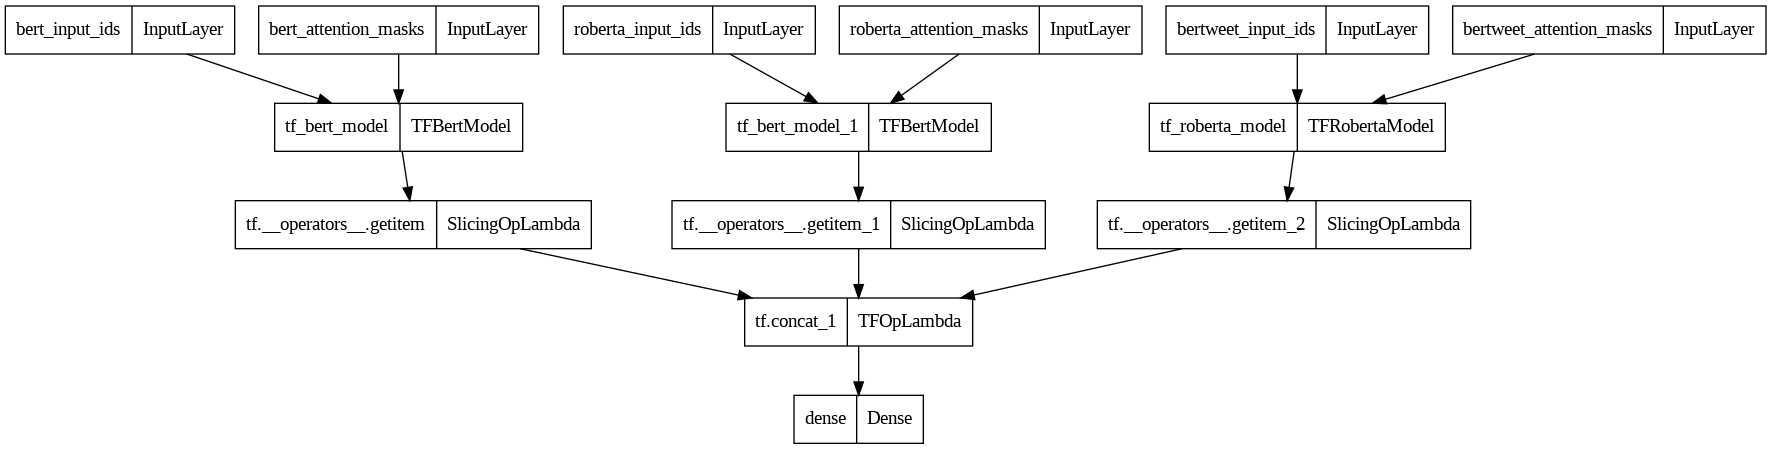

In [27]:
tf.keras.utils.plot_model(concat_model, 
                              #to_file='model_structure.png', 
                              #show_shapes = True,
                              show_layer_names = True)

In [28]:
train_encoded_input_ids_bert, train_encoded_attention_masks_bert = text_encode(df_train['full_text'], bert_tokenizer, MAX_LEN)
train_encoded_input_ids_roberta, train_encoded_attention_masks_roberta = text_encode(df_train['full_text'], roberta_tokenizer, MAX_LEN)
train_encoded_input_ids_bertweet, train_encoded_attention_masks_bertweet = text_encode(df_train['full_text'], bertweet_tokenizer, MAX_LEN)

In [31]:
def text_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer.batch_encode_plus(text, 
                          max_length = max_len, 
                          truncation = True, 
                          padding = 'max_length',
                          add_special_tokens = True,
                          return_attention_mask=True,
                          return_tensors="tf"
                          )
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

In [ ]:
def preprocess_data(sentence_pairs, label_strs, tokenizer, max_length=128):
    # With BERT tokenizer's batch_encode_plus, sentence pairs are
    # encoded together and separated by [SEP] token.
    encoded = tokenizer.batch_encode_plus(
        sentence_pairs,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="tf"
    )

    # Extract encoded features and labels, add to corresponding lists
    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")
    token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

    # Convert string labels into numbered categories
    labels = np.array([label_dict[label] if label in label_dict else 0
                       for label in label_strs])
    
    return [input_ids, attention_masks, token_type_ids], labels

In [34]:
class DataGeneratorFromFile(tf.keras.utils.Sequence):
    
    def __init__(self,
                 tokenizer_list,
                 n_examples,
                 data_filename,
                 max_length=MAX_LEN,
                 batch_size=4,
                 shuffle=True):
        
        self.tokenizer_list = tokenizer_list
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        # Return the number of batches in the full dataset
        return self.n_examples // self.batch_size
    
    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)
        
        texts = df_train['full_text'].values.astype(str).tolist()
        labels = df_train[label_cols].values
        
        batch_data = preprocess_data(
            texts,
            labels,
            self.tokenizer,
            self.max_length
        )

        return batch_data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))
# Create an instance of our data generator, for our training data file and size

train_data_generator = DataGeneratorFromFile(
    tokenizer_list=[bert_tokenizer, roberta_tokenizer, bertweet_tokenizer],
    n_examples=len(df_train),
    data_filename='train.csv'
)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]
print(get_cosine_similarity(train_encoded_attention_masks_bert, train_encoded_attention_masks_roberta))
print(get_cosine_similarity(train_encoded_attention_masks_bert, train_encoded_attention_masks_bertweet))
print(get_cosine_similarity(train_encoded_attention_masks_roberta, train_encoded_attention_masks_bertweet))

0.9883770581320539
0.9943667349881095
0.9875331107674594


In [ ]:
len(train_encoded_attention_masks_bert), len(train_encoded_attention_masks_roberta), len(train_encoded_attention_masks_bertweet)

(3128, 3128, 3128)

In [ ]:
y_train = np.array(df_train[label_cols], dtype = "float32")

In [ ]:
train_encoded_input_ids_bert[:5]

array([[  101,   146,  1341, ...,     0,     0,     0],
       [  101,  1332,   170, ...,  1106,  1838,   102],
       [  101, 12956,   117, ...,     0,     0,     0],
       [  101,  1109,  1436, ...,  2816,  1272,   102],
       [  101,  6844,  2496, ...,     0,     0,     0]])

In [ ]:
train_encoded_input_ids_roberta[:5]

array([[    0,   100,   206, ...,     1,     1,     1],
       [    0,  1779,    10, ...,     7,   192,     2],
       [    0, 23314,     6, ...,     1,     1,     1],
       [    0,   133,   275, ...,   216,    14,     2],
       [    0, 34647,  1760, ...,     1,     1,     1]])

In [ ]:
train_encoded_input_ids_bertweet[:5]

array([[    0,     8,   101, ...,     1,     1,     1],
       [    0,   205,    11, ...,     4,   104,     2],
       [    0, 45416,     7, ...,     1,     1,     1],
       [    0,    47,   161, ...,   369,    31,     2],
       [    0,  3997,   951, ...,     1,     1,     1]])

In [ ]:
len(train_encoded_attention_masks_bert), len(train_encoded_attention_masks_roberta), len(train_encoded_attention_masks_bertweet)

(3128, 3128, 3128)

In [ ]:
len(y_train)

3128

In [ ]:
hist = concat_model.fit([train_encoded_input_ids_bert, train_encoded_attention_masks_bert, 
                         train_encoded_input_ids_roberta, train_encoded_attention_masks_roberta,
                         train_encoded_input_ids_bertweet, train_encoded_attention_masks_bertweet],
                     y_train,
                     validation_split = .1,
                     batch_size = batch_size,        
                     epochs = epochs
                    )

df_history = pd.DataFrame(hist.history)

ResourceExhaustedError: ignored

In [ ]:
encoded_input_id_concatenated = tf.concat([train_encoded_input_ids_bert, train_encoded_input_ids_roberta, train_encoded_input_ids_bertweet], 0)
encoded_attention_masks_concatenated = tf.concat([train_encoded_attention_masks_bert, train_encoded_attention_masks_roberta, train_encoded_attention_masks_bertweet], 0)

In [ ]:
len(encoded_input_id_concatenated)

9384

In [ ]:
encoded_input_id_averaged = tf.math.reduce_mean([train_encoded_input_ids_bert, train_encoded_input_ids_roberta, train_encoded_input_ids_bertweet], 0)
encoded_attention_masks_averaged = tf.math.reduce_mean([train_encoded_attention_masks_bert, train_encoded_attention_masks_roberta, train_encoded_attention_masks_bertweet], 0)

In [ ]:
len(encoded_input_id_averaged), len(encoded_attention_masks_averaged)

(3128, 3128)

In [ ]:
concat_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                 loss      = MCRMSE,
                                 metrics   = MCRMSE
                                )